# Deep Q-Learning for Wordle

#### Content
1. The rules of the game
2. The concept of Deep-Q-Learning
3. Constructing the environment
4. The architecture of the model
5. Training results and tweaks
6. Sources

# 1. The rules of wordle

- Guess a five letter word in up to six attempts.
- After eacht attempt: Feedback for letters that are at the correct position / somewhere else / not at all in the solution.
- In the original version: 12972 allowed guesswords, 2309 potential solutions.

### Example

In [70]:
from wordle import Wordle
import random

In [71]:
solution = "bread"
game = Wordle(vocab=None, solution=solution)

In [72]:
game.play_visual("apple")
game.play_visual("berry")
game.play_visual("brake")
game.play_visual("bread")

Game over, you  won!


**Disclaimer:** This can be solved analytically with information theory. At each step there is an optimal word choice that minimizes entropy. But we're not here to do any of that.

After each guess, the game responds with one of $3^5$ seqeunces of green/yellow/grey-tiles. This means the potential number of different states per game is $(12972 * 3^5)^6 = 9.81 * 10^{38}$.  
This is way too big to be explicitly represented in e.g. a Q-table.  
&rarr; The expected reward has to be approximated by a parameterized function (a neural network) as a representation of policy π

# 2. Deep-Q-Learning

The idea behind Deep Q-Learning is to expand the single-step online updating of regular Q-learning with *experience replay* where the agent stores previous experience in a replay memory and periodically draws random samples from this memory to use as training data batches
- Experience can potentially be used in many weight updates &rarr; greater data efficiency
- Correlations between consecutive samples are broken &rarr; reduce the variance of updates
- Experiences from other action-sequences are used &rarr; less susceptible to path dependencies in online training

    Initialize action-value function Q with random weights
    for episodes M do
        for timesteps t do  
            with probability ε:                
                select action aₜ randomly
            else 
                select aₜ = max Q(φ(sₜ), θ)  
            Execute action aₜ 
            Observe reward rₜ and state sₜ₊₁ 
            Store transition (sₜ, aₜ, rₜ, sₜ₊₁) in replay memory
            Sample random minibatch (sₖ, aₖ, rₖ, sₖ₊₁) from replay memory
            for episode in minibatch do
                if episode terminates in sₖ₊₁
                    yₖ = rₖ
                else
                    Set yₖ = rₖ + γ * max Q(φ(sₖ₊₁), θ) 
                Perform gradient descent step on (yₖ − Q(φₖ, θ))²

# 3. Constructing the environment

### State space: 
- After each guess the game returns information for each letter at each position of the guessed word.
- In the visual representation this is $5*6$ combinations of green/yellow/grey tiles.
- The information of previus guesses should be included in the current state. This is done with a state vector of length $417$ that stores the following information:
     - `state[0]` for the index of the current round.
     - `state[1:26]` to remeber which letters have been guessed.
     - After that: $5 * 26 * 3$ features for the green/yellow/grey-information of each letter in each position.
         + Letter is definitely not in this spot: `[1, 0, 0]` 
         + Letter is maybe in this spot: `[0, 1, 0]`
         + Letter is definitely in this spot: `[0, 0, 1]`

### Action space:
- Originally: In each round any choice from the ~13k vocabulary is allowed. But only ~2.3k of these are poteniall solutions.
- To reduce the size of the action space, this environment limits the vocabulary to words that are potenital solutions.  
&rarr; The action space can be represented as a vector of vocabulary-length and interpreted eg. as a probability distribution for each word at the next round.

### Reward:
Balanced reward/cost for winnig and loosing:
+ $- 50$ for a lost game
+ $+ 50$ for a win

# 4. The Model

### General architecture
- The used model is constructed as a linear network with one hidden layer of size 256 and stochastic gradient descent optimization.  
- The model's input layer is of size $417$ to fit the state vector of the wordle environment.

### The model output
Each word from the vocabulary can be represented as a one hot encoded set of characters in each position, resulting in a vector of length $5 * 26 = 130$. This means the vocabulary itself can be represented as a matrix with 130 columns.  
This allows for a model with one of the following two ways to predict the next action (= choose a word from the vocabulary)
1. Use an output layer with a node for each word in the vocabulary
    - Simplest way to obtain action probabilities
    - The defining feature of a word is it's index position in the vocaulary
2. Use an output layer of length 130 that is multiplied with the vocabulary matrix in the forwarding step
    - The output layer can be semantically interpreted as weights for each letter and position
    - Similar words get similarly activated
    - The vocabulary can be shuffeled/changed  
    &rarr; Allows warm-starting of agents for larger vocabulary

# 5. Training results

In [1]:
import csv
import numpy as np
from matplotlib import pyplot as plt

def stats_plotter(paths, labels=None):
    for i in range(0, len(paths)):
        n_games = []
        recent_wins = []
        total_winrate = []
        with open(paths[i]) as stats_small:
            rows = csv.reader(stats_small, delimiter=",")
            for row in rows:
                n_games.append(int(row[0]))
                recent_wins.append(int(row[1]))
                total_winrate.append(float(row[2]))

        plt.scatter(x=n_games, y=recent_wins, label=labels[i] if labels else None)
    plt.xlabel("Number of games")
    plt.ylabel("Wins per 100")
    if labels:
        plt.legend(loc="lower right")
    plt.show()

Training was started with a minimal variant of the problem setting for bugfixing and general proof of concept. Training on a 100 word vocabulary with 20 possible solutions shows good results:

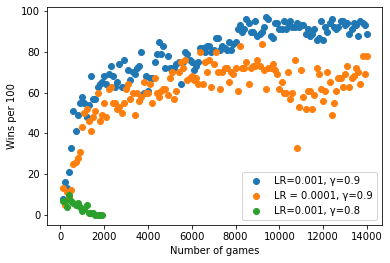

In [3]:
stats_plotter(["stats/v100s20.txt", "stats/v100s20lr0001.txt", "stats/v100s20g08.txt"], ["LR=0.001, γ=0.9", "LR = 0.0001, γ=0.9", "LR=0.001, γ=0.8"])

The following hyperparameters were used for the majority of the training sessions:
- Learning Rate = 0.001
- Gamma = 0.9
- Replay memory size = 10,000 (FIFO)
- Minibatch size = 1,000  

The model did however perform significantly worse on larger problems even with warm starting from previous training:

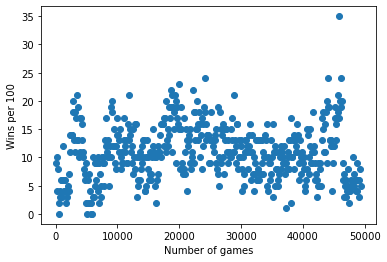

In [4]:
stats_plotter(["stats/v100.txt"])

One major problem was repeated guessing of the same word:

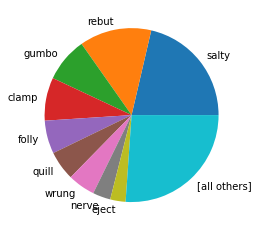

In [64]:
word = []
word_freq = []
with open("stats/word_hist.txt") as stats_small:
    rows = csv.reader(stats_small, delimiter=",")
    for row in rows:
        word.append(row[0])
        word_freq.append(int(row[1]))
plt.pie(x=word_freq, labels=word)
plt.set_cmap("hsv")
plt.show()

Multiple approaches to improve model performance were tried:
- **Overrepresent winners in the replay memory:**  
    The agent receives very little positive feedback in the beginning of a training session, this could be balanced by increasing the rate at wich winning moves are drawn for the experience replay step
- **Rewarding correct letters**  
    This approach rewards the agent for steps in the right direction as a way to increase positive feedback. This can lead to unwanted behaviour whith non winnig guesses that still average a relatively high reward
- **Penalize repeated guessing of the same word:**  
    This reduces variance in the histogram of guessed words but is hard to use for optimization since the previously guessed words of a round are only implicitly present in the state vector
- **Store more information in the state vector**  
    Training was started with a smaller state vector that did not include guessed letters and the current round. Making this information more explicit helped in improving performance

# Sources

- Anderson, Benton et al. (2022): [Finding the optimal human strategy for Wordle using maximum correct letter probabilities and reinforcement learning](https://arxiv.org/abs/2202.00557)
- Ho, Andrew (2022): [Solving Wordle with Reinforcement Learning](https://wandb.ai/andrewkho/wordle-solver/reports/Solving-Wordle-with-Reinforcement-Learning--VmlldzoxNTUzOTc4)
- Loeber, Patrick (2022): [Train an AI to Play Snake](https://www.youtube.com/watch?v=L8ypSXwyBds) 
- Mnih, Volodymyr (2018): [Deep RL Bootcamp Lecture Deep Q-Networks](https://www.youtube.com/watch?v=fevMOp5TDQs)
- Mnih, Volodymyr et al.(2013): [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)
- Sanderson, Grant (2022): [Solving Wordle using information theory](https://www.youtube.com/watch?v=v68zYyaEmEA)